<a href="https://colab.research.google.com/github/theresiabp/Colab-practice/blob/main/METAR_StationPlots_metpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy
!pip install metpy

In [ ]:
!pip install siphon

In [ ]:
from siphon.catalog import TDSCatalog

In [ ]:
cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

In [ ]:
ds = cat.datasets['metar_20230830_1200.txt']

In [ ]:
ds.download()

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from metpy.calc import reduce_point_density
from metpy.io import metar
from metpy.plots import current_weather, sky_cover, StationPlot

In [ ]:
from metpy.io import parse_metar_file

In [ ]:
df = parse_metar_file(ds.name)

In [ ]:
df.head()

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
K27K,K27K,38.233333,-84.433333,289.0,2023-09-30 11:55:00,0.0,0.0,NaN,16093.44,NaN,...,15.0,14.0,29.92,0,0,0,AO1,1013.39,-0.000000e+00,-0.0
MMCS,MMCS,31.620000,-106.420000,1171.0,2023-09-30 11:40:00,0.0,0.0,NaN,16093.44,NaN,...,22.0,14.0,30.19,0,0,0,SLP101 5//// 906 8/530 RTS,1017.60,-0.000000e+00,-0.0
KMCX,KMCX,40.720000,-86.770000,206.0,2023-09-30 11:55:00,0.0,0.0,NaN,16093.44,NaN,...,11.0,11.0,30.01,0,0,0,AO2 60001 70012 T01120105 10165 20110,1016.86,-0.000000e+00,-0.0
MMCU,MMCU,28.700000,-105.970000,1372.0,2023-09-30 11:40:00,0.0,0.0,NaN,16093.44,NaN,...,17.0,15.0,30.19,0,0,0,SLP117 5//// 902 8/001 RTS,1019.14,-0.000000e+00,-0.0
KSUA,KSUA,27.180000,-80.220000,6.0,2023-09-30 11:47:00,180.0,15.0,21.0,16093.44,NaN,...,28.0,24.0,29.79,0,0,0,,1009.07,-1.836970e-15,15.0


In [ ]:
df = df.dropna(how='any', subset=['wind_direction', 'wind_speed'])

In [ ]:
# Set up the map projection
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,
                             standard_parallels=[35])
# Use the Cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 100km radius
point_locs = proj.transform_points(ccrs.PlateCarree(), df['longitude'].values,
                                   df['latitude'].values)
df = df[reduce_point_density(point_locs, 75000.)]

# Convert Celsius to Fahrenheit
df['air_temperature'] = (df['air_temperature'] * 1.8) + 32
df['dew_point_temperature'] = (df['dew_point_temperature'] * 1.8) + 32

<ipython-input-46-faf58e095643>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['air_temperature'] = (df['air_temperature'] * 1.8) + 32
<ipython-input-46-faf58e095643>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dew_point_temperature'] = (df['dew_point_temperature'] * 1.8) + 32


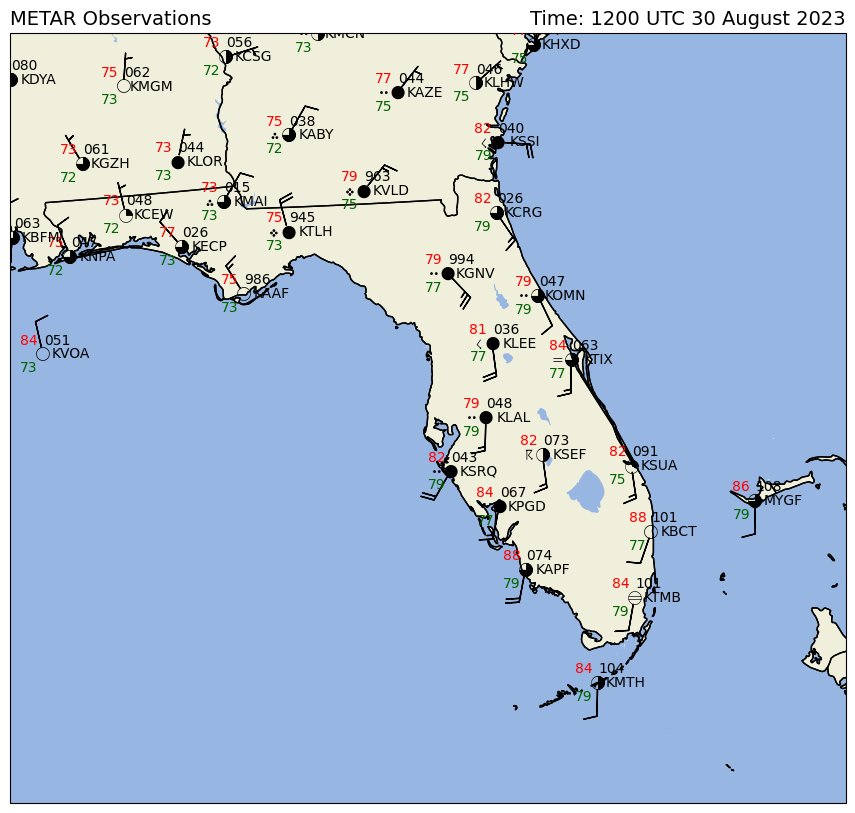

In [ ]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
ax.set_extent((-88, -78, 24, 32))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, df['longitude'].values, df['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', df['air_temperature'].values, color='red')
stationplot.plot_parameter('SW', df['dew_point_temperature'].values,
                           color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', df['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', df['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', df['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(df['eastward_wind'].values, df['northward_wind'].values)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((2, 0), df['station_id'].values)

plt.title('METAR Observations', fontsize=14, loc='left')
plt.title('Time: 1200 UTC 30 August 2023', fontsize=14, loc='right')
plt.show()

In [ ]:
  from google.colab import files

  image = fig
  image.savefig('METAR-sample-py.jpg',  bbox_inches="tight")
  files.download('METAR-sample-py.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>